# Import Library

In [ ]:
# Import library
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import math, os, sys
import itertools
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
plt.style.use('default')

from scipy import ndimage
from skimage import measure, morphology
from skimage.io import imsave, imread
from skimage.filters import threshold_otsu
from skimage.transform import resize

import tensorflow as tf
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
import pandas as pd

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

In [ ]:
# Tampilkan versi TensorFlow
print("TensorFlow Version:", tf.__version__)
print(tf.__version__)

TensorFlow Version: 2.18.0
2.18.0


# Import dataset

In [ ]:
!pip install kaggle

In [ ]:
# Import module yang disediakan google colab untuk kebutuhan upload file

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"msyarifhidayat","key":"1c8f7433900b5c279d9b12555cfd635d"}'}

In [ ]:
# Pastikan direktori .kaggle ada
!mkdir -p ~/.kaggle

# Pindahkan kaggle.json ke folder yang benar
!mv kaggle.json ~/.kaggle/

# Berikan izin akses ke file
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset dari Kaggle
!kaggle datasets download -d dilaaurafutri/dataset-skintype-capstone

# Unzip file dataset
!unzip -q dataset-skintype-capstone.zip -d dataset-skintype-capstone

Dataset URL: https://www.kaggle.com/datasets/dilaaurafutri/dataset-skintype-capstone
License(s): unknown
100% 827M/827M [00:07<00:00, 87.5MB/s]
100% 827M/827M [00:07<00:00, 120MB/s] 


In [ ]:
!ls dataset-skintype-capstone/dataset_skintype_capstone

test  train  valid


In [ ]:
# Set paths
DATA_DIR = "dataset-skintype-capstone/dataset_skintype_capstone"
DATA_TRAIN = os.path.join(DATA_DIR, "train")
DATA_VALID = os.path.join(DATA_DIR, "valid")
DATA_TEST = os.path.join(DATA_DIR, "test")

MODEL_SAVE_PATH = "/content/drive/MyDrive/vit_skin_model.pth"
LOG_DIR = "/content/logs/vit"

# Create log directory
import os
os.makedirs(LOG_DIR, exist_ok=True)

print(f"Data directory: {DATA_DIR}")
print(f"Train directory: {DATA_TRAIN}")
print(f"Validation directory: {DATA_VALID}")
print(f"Test directory: {DATA_TEST}")
print(f"Model save path: {MODEL_SAVE_PATH}")
print(f"TensorBoard logs directory: {LOG_DIR}")


Data directory: dataset-skintype-capstone/dataset_skintype_capstone
Train directory: dataset-skintype-capstone/dataset_skintype_capstone/train
Validation directory: dataset-skintype-capstone/dataset_skintype_capstone/valid
Test directory: dataset-skintype-capstone/dataset_skintype_capstone/test
Model save path: /content/drive/MyDrive/vit_skin_model.pth
TensorBoard logs directory: /content/logs/vit


In [ ]:
import os

# Cek apakah direktori test ada
print("Isi folder train:")
print(os.listdir(DATA_TRAIN))
print("Isi folder valid:")
print(os.listdir(DATA_VALID))
print("Isi folder test:")
print(os.listdir(DATA_TEST))


# Coba lihat isi dari salah satu label, misalnya 'oily'
oily_path = os.path.join(DATA_TRAIN, 'oily')
if os.path.exists(oily_path):
    print("\nIsi folder test/oily:")
    print(os.listdir(oily_path))
else:
    print("\nFolder 'oily' tidak ditemukan di dalam TEST_DIR!")



Isi folder train:
['dry', 'oily', 'normal']
Isi folder valid:
['dry', 'oily', 'normal']
Isi folder test:
['dry', 'oily', 'normal']

Isi folder test/oily:
['oily-skin_41_jpeg_jpg.rf.569dcd20e7c0ce089e78335538750501.jpg', 'oily47_jpg.rf.fe194585da99c20c2734b71aef159688.jpg', 'a6417a227147e211f04195904db59d42.jpg', 'faf437c241b79bec07f52fe90402977d.jpg', 'oily_3fe4adc9d6c9bcead953_jpg.rf.8abc15ab699864fe66a3425a69f21450.jpg', 'oily_7a071fda3e1e2d3ec0c7_jpg.rf.ff89a078846d0108b39612f845e0c172 - Copy.jpg', 'oily38_jpg.rf.1f18ecffe69db4288f2a6d7b3f60575f.jpg', 'f52290dcfd3db586c01028ba1e77f3ec.jpg', 'face-skin-and-beauty-portrait-of-a-woman-with-nat-2025-04-06-09-03-35-utc.jpg', 'af2e709f587cb4b9ccccc1442276d004.jpg', 'portrait-of-beautiful-african-american-girl-lookin-2024-11-18-01-38-39-utc.jpg', '7d7fd3b4bfabc803738c343ab9415c9c.jpg', 'd8e8ab17f0ff47fc988899019e398589.jpg', 'cheerful-and-young-asian-woman-with-blemishes-on-w-2024-11-15-10-41-04-utc.jpg', '080698e51d5eaa5c21d9a298facd39f5.

Jumlah gambar: 50


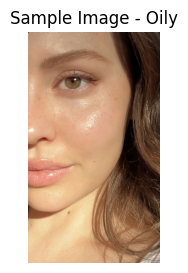

In [ ]:
sample_image_path = os.path.join(DATA_TEST, 'oily')  # Ganti 'oily' ke folder yang tersedia
sample_image_list = os.listdir(sample_image_path)
print("Jumlah gambar:", len(sample_image_list))

sample_image = imread(os.path.join(sample_image_path, sample_image_list[40]))

plt.figure(figsize=(3,3))
plt.imshow(sample_image)
plt.title("Sample Image - Oily")
plt.axis('off')
plt.show()


# Preprocessing

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Konfigurasi
IMG_SHAPE = (224, 224, 3)
BATCH_SIZE = 32

# Path ke folder dataset


# =========================
# 1. Data Preprocessing
# =========================
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    DATA_TRAIN,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = valid_datagen.flow_from_directory(
    DATA_VALID,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 1199 images belonging to 3 classes.
Found 150 images belonging to 3 classes.


# Modelling

In [ ]:
# Define and compile the model - This section was commented out and needs to be active
from tensorflow.keras.applications import MobileNetV2

IMG_SHAPE = (224, 224, 3)

# Load pre-trained MobileNetV2
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet'
)

# Freeze base model temporarily (optional, can fine-tune later)
base_model.trainable = False

# Add Fully Connected (FC) layer on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)         # 1st additional FC layer
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)         # 2nd additional FC layer
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)          # 3rd additional FC layer
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)          # 4rd additional FC layer
x = Dropout(0.3)(x)
output = Dense(3, activation='softmax')(x)  # Output layer

# Combine into the final model
model = Model(inputs=base_model.input, outputs=output)


# Compile model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# See structure
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,629,251 (10.03 MB)

 Trainable params: 371,267 (1.42 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# =========================
# 3. Initial Training (FC Layers)
# =========================
# Now that the model is defined and compiled, this should work
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.3527 - loss: 1.2101 - val_accuracy: 0.5133 - val_loss: 1.0290
Epoch 2/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.4714 - loss: 1.0454 - val_accuracy: 0.5400 - val_loss: 0.9549
Epoch 3/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.4958 - loss: 0.9908 - val_accuracy: 0.5867 - val_loss: 0.8984
Epoch 4/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.5626 - loss: 0.9585 - val_accuracy: 0.6067 - val_loss: 0.8663
Epoch 5/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.5933 - loss: 0.9099 - val_accuracy: 0.6467 - val_loss: 0.8335
Epoch 6/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.6245 - loss: 0.8565 - val_accuracy: 0.6600 - val_loss: 0.8107
Epoch 7/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.6311 - loss: 0.8420 - val_accuracy: 0.6933 - val_loss: 0.7419
Epoch 8/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.6511 - loss: 0.8012 - val_accuracy: 0.6933 - val_loss:

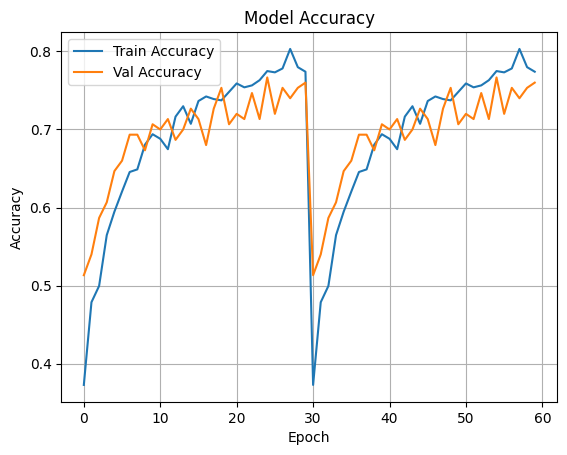

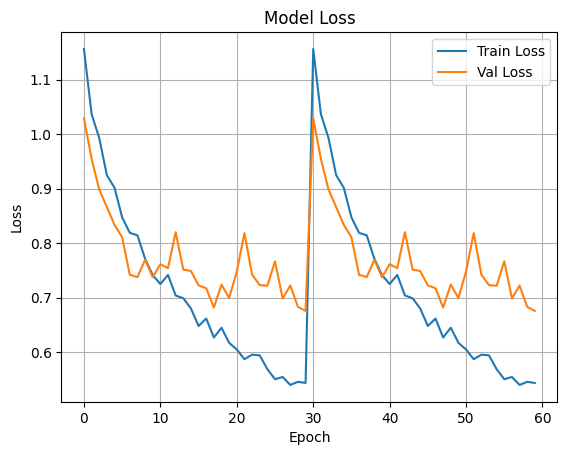

In [ ]:
# =========================
# 5. Plot History
# =========================
plt.plot(history.history['accuracy'] + history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'] + history.history['val_accuracy'], label='Val Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

plt.plot(history.history['loss'] + history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'] + history.history['val_loss'], label='Val Loss')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Menyimpan Label

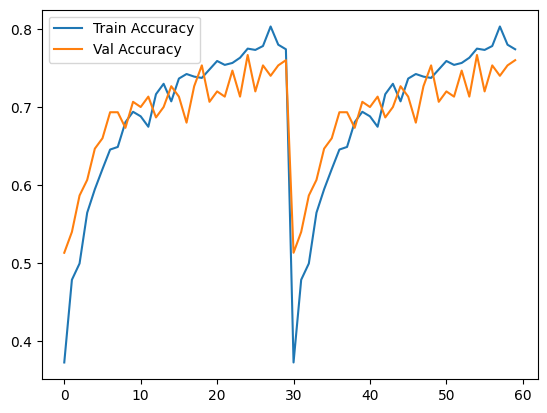

In [ ]:
# Visualisasi hasil semua pelatihan
plt.plot(history.history['accuracy'] + history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'] + history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.show()


# Evaluasi

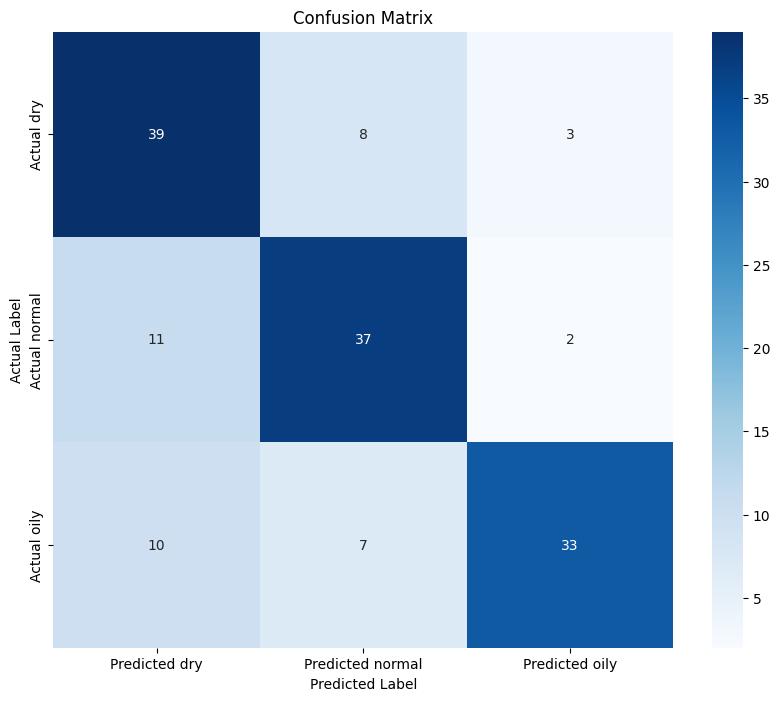


Classification Report:

              precision    recall  f1-score   support

         dry     0.6500    0.7800    0.7091        50
      normal     0.7115    0.7400    0.7255        50
        oily     0.8684    0.6600    0.7500        50

    accuracy                         0.7267       150
   macro avg     0.7433    0.7267    0.7282       150
weighted avg     0.7433    0.7267    0.7282       150



In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Reset generator agar urutan batch konsisten
val_generator.reset()

# Dapatkan prediksi probabilitas dari model
preds_1 = model.predict(val_generator, verbose=0)

# Ambil prediksi kelas (kelas dengan probabilitas tertinggi)
pred_classes = np.argmax(preds_1, axis=1)

# Ambil label asli
true_classes = val_generator.classes

# Ambil nama label (pastikan urutannya sama dengan class_indices)
label_map = val_generator.class_indices
label_names = [label for label, index in sorted(label_map.items(), key=lambda x: x[1])]

# Confusion Matrix
cm = pd.DataFrame(
    confusion_matrix(true_classes, pred_classes),
    index=[f"Actual {label}" for label in label_names],
    columns=[f"Predicted {label}" for label in label_names]
)

# Tampilkan heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.show()

# Tampilkan classification report
print("\nClassification Report:\n")
print(classification_report(
    y_true=true_classes,
    y_pred=pred_classes,
    target_names=label_names,
    digits=4
))


# Konversi Model

In [ ]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.2 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
google-cloud-bigquery 3.34.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [ ]:
# ==================================================================================
# IMPORT LIBRARY
# ==================================================================================
import tensorflow as tf
import tensorflowjs as tfjs
import os
from google.colab import files
import zipfile

# ==================================================================================
# 1. SAVE AS HDF5 (.h5 format)
# ==================================================================================
h5_path = "/content/model.h5"
model.save(h5_path)
print(f"✅ HDF5 model saved as: {h5_path}")

# ==================================================================================
# 2. SAVE AS TENSORFLOWJS FORMAT (.json + .bin files)
# ==================================================================================
tfjs_folder = "/content/model_tfjs"
os.makedirs(tfjs_folder, exist_ok=True)

print("Saving TensorFlow.js format...")
try:
    tfjs.converters.save_keras_model(model, tfjs_folder)
    print(f"✅ TensorFlow.js model saved in: {tfjs_folder}")
    for file in os.listdir(tfjs_folder):
        print(f"  - {file}")
except Exception as e:
    print(f"❌ TensorFlow.js saving error: {e}")
    temp_keras_path = "/content/temp_model.keras"
    model.save(temp_keras_path)
    tfjs.converters.save_keras_model(temp_keras_path, tfjs_folder)
    os.remove(temp_keras_path)
    print(f"✅ TensorFlow.js model saved in: {tfjs_folder} (via .keras)")
    for file in os.listdir(tfjs_folder):
        print(f"  - {file}")

# ==================================================================================
# 3. SAVE AS SAVEDMODEL FORMAT (.pb + variables folder)
# ==================================================================================
savedmodel_folder = "/content/model_savedmodel"
os.makedirs(savedmodel_folder, exist_ok=True)

print("\nSaving SavedModel format...")
try:
    tf.saved_model.save(model, savedmodel_folder)
    print(f"✅ SavedModel saved in: {savedmodel_folder}")
except Exception as e:
    print(f"❌ SavedModel saving error: {e}")
    keras_path = "/content/model.keras"
    model.save(keras_path)
    print(f"⚠️ Saved as .keras format instead: {keras_path}")
    savedmodel_folder = keras_path

# ==================================================================================
# 4. SAVE AS TFLITE FORMAT (.tflite)
# ==================================================================================
print("\nConverting to TensorFlow Lite format...")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

tflite_path = "/content/model.tflite"
with open(tflite_path, 'wb') as f:
    f.write(tflite_model)

print(f"✅ TensorFlow Lite model saved as: {tflite_path}")
print(f"File size: {os.path.getsize(tflite_path) / 1024:.2f} KB")

# ==================================================================================
# 5. CREATE LABELS FILE
# ==================================================================================
class_labels = ['dry', 'normal', 'oily']
labels_path = "/content/labels.txt"
with open(labels_path, 'w') as f:
    for label in class_labels:
        f.write(f"{label}\n")

print(f"✅ Labels file saved as: {labels_path}")
print("Labels:")
for i, label in enumerate(class_labels):
    print(f"  {i}: {label}")

# ==================================================================================
# 6. ZIP & DOWNLOAD FILES
# ==================================================================================
print("\nZipping and downloading files...")

# TensorFlow.js
tfjs_zip_path = "/content/model_tfjs.zip"
with zipfile.ZipFile(tfjs_zip_path, 'w') as zipf:
    for root, _, files in os.walk(tfjs_folder):
        for file in files:
            path = os.path.join(root, file)
            arcname = os.path.relpath(path, tfjs_folder)
            zipf.write(path, arcname)

# SavedModel
savedmodel_zip_path = "/content/model_savedmodel.zip"
with zipfile.ZipFile(savedmodel_zip_path, 'w') as zipf:
    if os.path.isdir(savedmodel_folder):
        for root, _, files in os.walk(savedmodel_folder):
            for file in files:
                path = os.path.join(root, file)
                arcname = os.path.relpath(path, savedmodel_folder)
                zipf.write(path, arcname)
    else:
        zipf.write(savedmodel_folder, os.path.basename(savedmodel_folder))

# Production SavedModel
production_folder = "/content/production_savedmodel"
os.makedirs(production_folder, exist_ok=True)

@tf.function
def serve_fn(input_tensor):
    return model(input_tensor)

concrete_func = serve_fn.get_concrete_function(tf.TensorSpec([None, 150, 150, 1], tf.float32))

tf.saved_model.save(
    model,
    production_folder,
    signatures={'serving_default': concrete_func}
)

# Zip Production Model
production_zip_path = "/content/production_savedmodel.zip"
with zipfile.ZipFile(production_zip_path, 'w') as zipf:
    for root, _, files in os.walk(production_folder):
        for file in files:
            path = os.path.join(root, file)
            arcname = os.path.relpath(path, production_folder)
            zipf.write(path, arcname)

# Download all
print("Downloading models and labels...")
files.download(tfjs_zip_path)
files.download(savedmodel_zip_path)
files.download(production_zip_path)
files.download(tflite_path)
files.download(h5_path)
files.download(labels_path)

print("\n✅ Semua file berhasil disimpan dan siap diunduh!")

# ==================================================================================
# 7. VERIFIKASI PEMUATAN MODEL
# ==================================================================================
print("\nVerifikasi model...")

try:
    loaded_model = tf.keras.models.load_model(h5_path)
    print("✅ .h5 model loaded successfully")
except Exception as e:
    print(f"❌ Error loading .h5: {e}")

try:
    if os.path.isdir(savedmodel_folder):
        loaded_sm = tf.saved_model.load(savedmodel_folder)
        print("✅ SavedModel loaded successfully")
    else:
        loaded_sm = tf.keras.models.load_model(savedmodel_folder)
        print("✅ Keras (.keras) model loaded successfully")
except Exception as e:
    print(f"❌ Error loading SavedModel: {e}")

try:
    interpreter = tf.lite.Interpreter(model_path=tflite_path)
    interpreter.allocate_tensors()
    print("✅ TFLite model loaded successfully")
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    print(f"  Input: {input_details[0]['shape']}")
    print(f"  Output: {output_details[0]['shape']}")
except Exception as e:
    print(f"❌ Error loading TFLite model: {e}")


✅ HDF5 model saved as: /content/model.h5
Saving TensorFlow.js format...
failed to lookup keras version from the file,
    this is likely a weight only file
✅ TensorFlow.js model saved in: /content/model_tfjs
  - group1-shard3of3.bin
  - group1-shard1of3.bin
  - group1-shard2of3.bin
  - model.json

Saving SavedModel format...
✅ SavedModel saved in: /content/model_savedmodel

Converting to TensorFlow Lite format...
Saved artifact at '/tmp/tmp1uenu7ws'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  137472331920976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137472331990032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137472331989264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137472331921744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137472331912336: 

ValueError: in user code:

    File "<ipython-input-18-523863043>", line 117, in serve_fn  *
        return model(input_tensor)
    File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/input_spec.py", line 245, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "functional" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(None, 150, 150)


In [ ]:
import zipfile
import os
from google.colab import files

# 1. Nama file zip hasilnya
zip_filename = '/content/custom_export.zip'

# 2. Buat file ZIP dan tambahkan file/folder tertentu
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    # Tambahkan folder tfjs_model
    tfjs_path = '/content/tfjs_model'
    for root, dirs, files_ in os.walk(tfjs_path):
        for file in files_:
            full_path = os.path.join(root, file)
            rel_path = os.path.relpath(full_path, '/content')
            zipf.write(full_path, rel_path)

    # Tambahkan file model.tflite
    tflite_file = '/content/model.tflite'
    if os.path.exists(tflite_file):
        rel_path = os.path.relpath(tflite_file, '/content')
        zipf.write(tflite_file, rel_path)

    # Tambahkan folder model_tfjs
    tfjs_folder = '/content/model_tfjs'
    if os.path.exists(tfjs_folder):
        for root, dirs, files_ in os.walk(tfjs_folder):
            for file in files_:
                full_path = os.path.join(root, file)
                rel_path = os.path.relpath(full_path, '/content')
                zipf.write(full_path, rel_path)

    # Tambahkan folder model_savedmodel
    saved_model_folder = '/content/model_savedmodel'
    if os.path.exists(saved_model_folder):
        for root, dirs, files_ in os.walk(saved_model_folder):
            for file in files_:
                full_path = os.path.join(root, file)
                rel_path = os.path.relpath(full_path, '/content')
                zipf.write(full_path, rel_path)

print(f"File ZIP berhasil dibuat: {zip_filename}")

# 3. Unduh file ZIP ke lokal
files.download(zip_filename)
